### 3. Connection to query characterisitcs

In [ ]:
import importlib
import numpy as np
import matplotlib.pylab as plt
from matplotlib import rc
import seaborn as sns
from sql_metadata import Parser


from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve

import support_functions
import uncertainty_data_path_consts as data_constants

PAUQ_DB_PATH = "/pauq/pauq_databases"
EHRSQL_MIMIC_PATH = "/mimic_iv/mimic_iv.sqlite"

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
%config InlineBackend.figure_format = 'retina'

importlib.reload(support_functions)
importlib.reload(data_constants)

In [3]:
def calculate_query_length_feature(gold_list, pred_dict):
    length_list = []
    for sample in gold_list:
        id_ = sample['id']
        sql = pred_dict[id_]['sql']
        length = len(sql.split())
        length_list.append(length)
    return length_list

def calculate_number_of_schema_items(gold_list, pred_dict):
    schema_elements_amount_list = []
    for sample in gold_list:
        id_ = sample['id']
        sql = pred_dict[id_]['sql']
        try:
            parsed_sql = Parser(sql)
            tables_amount = len(parsed_sql.tables)
            columns_amount = len(parsed_sql.columns)
            schema_elements = tables_amount + columns_amount
        except:
            schema_elements = 0
        schema_elements_amount_list.append(schema_elements)
    return schema_elements_amount_list

### Generated Query length relation

In [4]:
from sklearn.metrics import fbeta_score


BETA_FINE=3

def score_by_gmm(dev_sc, dev_tr, test_sc, test_tr):
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(dev_scores, dev_targets)
        calibrated_cls_test = calibrated_cls.predict_proba(test_scores)[:, 1].reshape(-1,1)
        
        gmm = GaussianMixture(n_components=2, random_state=42).fit(calibrated_cls_test)
        
        calibrated_cls_pred_target = gmm.predict(calibrated_cls_test)
        calibrated_cls_pred_target_inverted = [1 if x == 0 else 0 for x in calibrated_cls_pred_target]
        
        calibrated_cls_pred_proba = gmm.predict_proba(calibrated_cls_test)[:, 1]
        calibrated_cls_pred_proba_inverted = [1 - x for x in calibrated_cls_pred_proba]
        
        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, calibrated_cls_pred_target, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, calibrated_cls_pred_target_inverted, pos_label=1, beta=BETA_FINE)
        if score > inverted_score:
            predicted_test_targets.append(calibrated_cls_pred_target)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba)
        else:
            predicted_test_targets.append(calibrated_cls_pred_target_inverted)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba_inverted)
    
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T

    return predicted_test_targets_matrix, predicted_test_proba_matrix


def score_by_logreg(dev_sc, dev_tr, test_sc, test_tr):
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(dev_scores, dev_targets)
        calibrated_cls = lr.fit(dev_scores, dev_targets)
        
        calibrated_cls_pred_target = calibrated_cls.predict(test_scores)
        calibrated_cls_pred_proba = calibrated_cls.predict_proba(test_scores)[:, 1]
        
        calibrated_cls_pred_target_inverted = [1 if x == 0 else 0 for x in calibrated_cls_pred_target]
        calibrated_cls_pred_proba_inverted = [1 - x for x in calibrated_cls_pred_proba]

        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, calibrated_cls_pred_target, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, calibrated_cls_pred_target_inverted, pos_label=1, beta=BETA_FINE)
        
        if score > inverted_score:
            predicted_test_targets.append(calibrated_cls_pred_target)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba)
        else:
            predicted_test_targets.append(calibrated_cls_pred_target_inverted)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba_inverted)
        
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T
    
    return predicted_test_targets_matrix, predicted_test_proba_matrix


def evaluate_predictions(predicted_matrix, predicted_scores_matrix, gold_matrix, name):
    
    metric_dict = {'recall': recall_score, 'precision': precision_score, 'f_score': fbeta_score}
    seed_number = range(predicted_matrix.shape[1])
    metric_score_dict = dict()
    for metric, metric_func in metric_dict.items():
        score_list = []
        for i in seed_number:
            predicted_vector, gold_vector = predicted_matrix[:, i], gold_matrix[:, i]
            if metric == 'f_score':
                score = metric_func(gold_vector, predicted_vector, beta=BETA_FINE)
            else:
                score = metric_func(gold_vector, predicted_vector, pos_label=1)
            score_list.append(score)
        mean, std = np.mean(score_list), np.std(score_list)
        metric_score_dict[metric] = {"mean": round(mean,2), "std": round(std, 2)}
    
    # if name != 'Threshold':
    auc_score_list = []

    fpr_list, tpr_list = [], []
    for i in seed_number:
        predicted_scores_vector, gold_vector = predicted_scores_matrix[:, i], gold_matrix[:, i]
        score = roc_auc_score(gold_vector, predicted_scores_vector, average='micro')
        auc_score_list.append(score)

    mean, std = np.mean(auc_score_list), np.std(auc_score_list)
    metric_score_dict['AUC-ROC'] = {"mean": round(mean,2), "std": round(std, 3)}

    gold_vector = np.array([np.bincount(row).argmax() for row in gold_matrix]).reshape(-1,1)
    fpr, tpr, _ = roc_curve(gold_vector, predicted_scores_matrix.mean(axis=1), pos_label=1)


    metric_score_dict['FPR'] = fpr
    metric_score_dict['TPR'] = tpr

    
    return metric_score_dict


def score_by_thresh(dev_sc, dev_tr, test_sc, test_tr):
    def get_threshold(score_list, exec_list):

        scores = score_list
        target = exec_list

        sorted_indices = np.argsort(scores)
        sorted_scores = np.array(scores)[sorted_indices]
        sorted_targets = np.array(target)[sorted_indices]

        max_score, threshold = 0, -1
        for idx in range(len(sorted_targets)):
            cum_score = sum(sorted_targets[:idx+1])
            if cum_score > max_score:
                # print('cum_score > max_score')
                max_score, threshold = cum_score, sorted_scores[idx-1]

        return threshold  # We abstain if maxent is greater than this threshold.
    
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        test_scores = test_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]


        calibrated_cls_dev_pred = dev_scores
        calibrated_cls_test_pred = test_scores
        
        
        treshold = get_threshold(calibrated_cls_dev_pred, dev_targets)
        tresh_preds_list = []
        for score in calibrated_cls_test_pred:
            if score > treshold:
                tresh_preds_list.append(1)
            else:
                tresh_preds_list.append(0)
                
        tresh_preds_list_inverted = [1 if x == 0 else 0 for x in tresh_preds_list]
        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, tresh_preds_list, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, tresh_preds_list_inverted, pos_label=1, beta=BETA_FINE)

        if score > inverted_score:
            predicted_test_targets.append(tresh_preds_list)
        else:
            predicted_test_targets.append(tresh_preds_list_inverted)
            
        min_score, max_score = np.min(calibrated_cls_dev_pred, axis=0), np.max(calibrated_cls_dev_pred, axis=0)
        calibrated_cls_test_pred = (calibrated_cls_test_pred - min_score) / (max_score - min_score)
        calibrated_cls_test_pred = np.clip(calibrated_cls_test_pred, 0, 1).flatten().tolist()
        predicted_test_targets_proba.append(calibrated_cls_test_pred)
        
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T
    
    return predicted_test_targets_matrix, predicted_test_proba_matrix

#### Test

100%|██████████████████████████████████████| 1076/1076 [00:04<00:00, 263.27it/s]


(1076, 3) (1076, 3)


NameError: name 'dev_scores_matrix' is not defined

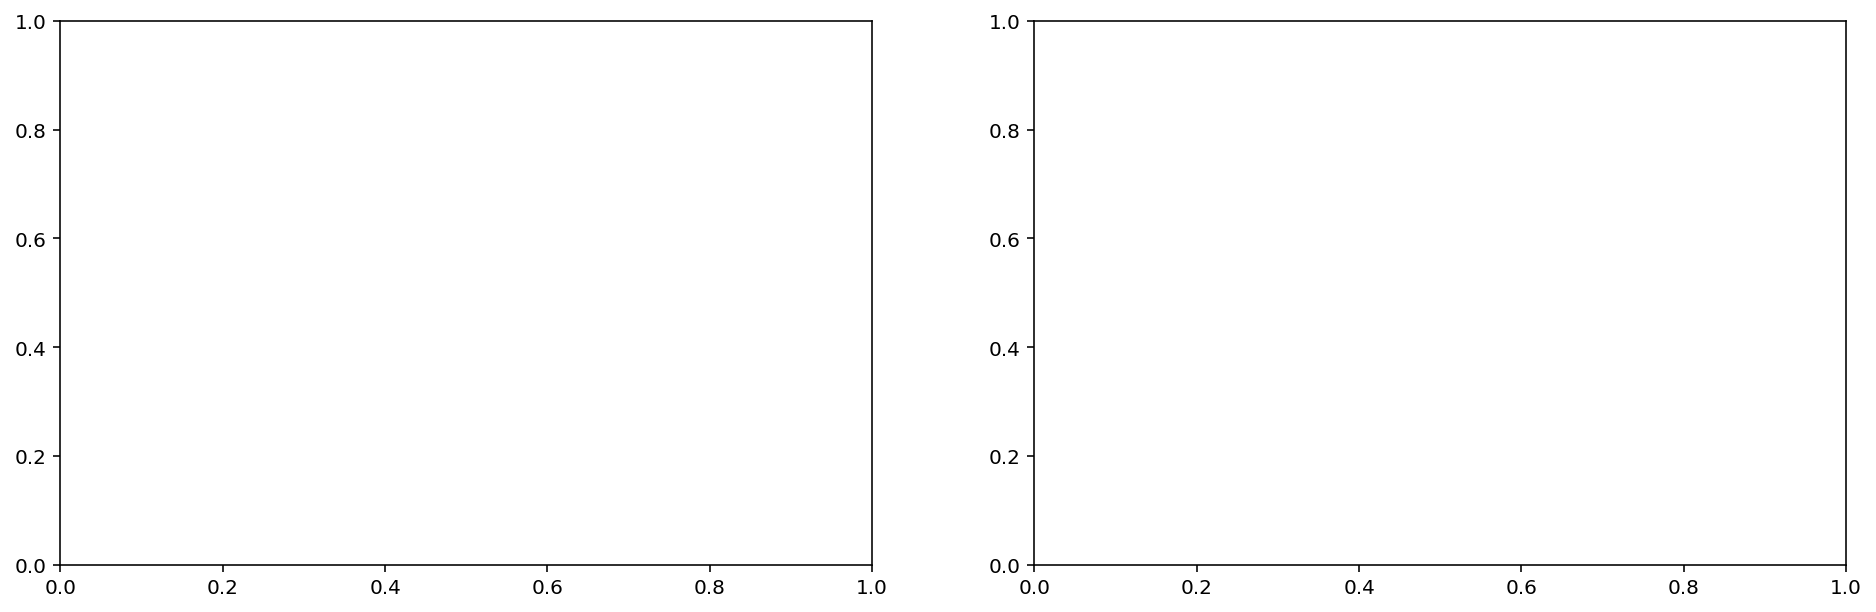

In [107]:
model_name = 't5-large'
split_name = 'pauq_xsp'

fig, axs = plt.subplots(1, 2, figsize=(16, 5))


scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
seeds = data_constants.SEED_LIST[model_name]
gold_list = support_functions.read_gold_dataset_test(split_name, data_constants.GOLD_TEST_SPLIT_PATH)
length_vector = np.zeros((len(gold_list), 1))
for seed in seeds:
    predicted_dict = support_functions.read_preds_dataset_test(split_name, model_name, seed,
                                                        data_constants.SPLITS_PREDICTIONS_PATH)
    length_vector += calculate_query_length_feature(gold_list, predicted_dict)

length_avg_vector = (length_vector / len(seeds)).reshape(-1)
scores_avg_vector = scores.mean(axis=1).reshape(-1,1).reshape(-1)
major_target_vector = np.array([np.bincount(row).argmax() for row in targets]).reshape(-1).tolist()
major_target_list = ['True EX' if x == 1 else "False EX" for x in major_target_vector ]


plot_title = f"{model_name} for {data_constants.SPLITS_NAMES[split_name]}"

axs[0].set_title(plot_title)
sns.scatterplot(x=length_avg_vector, y=scores_avg_vector, hue = major_target_list, ax= axs[0])

### Length to confidence

100%|████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 419610.18it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 384414.73it/s]


(1167, 3) (1167, 3)


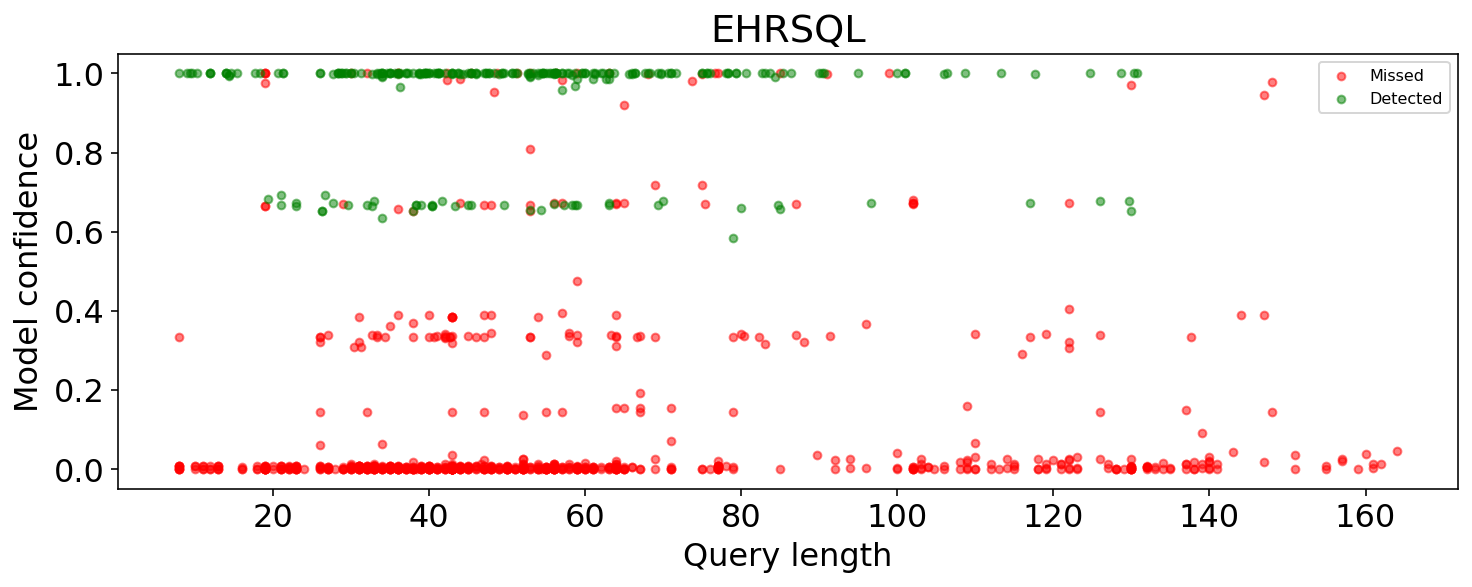

In [12]:
import random

plt.rcParams.update({'font.size': 16})

model_name_list = ['t5-large', 't5-3b',]
splits = ['ehrsql']

fig, axs = plt.subplots(1, len(splits), figsize=(12, 4))


for split_idx, split_name in enumerate(splits):
    lenght_array = np.array([-1])
    scores_array = np.array([-1])
    predicted_targets_array = np.array([-1])
    for model_idx, model_name in enumerate(model_name_list):
    
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            pred, proba_preds = score_by_gmm(dev_sc, dev_tr, test_sc, test_tr)
            
            seeds = data_constants.SEED_LIST[model_name]
            gold_list = support_functions.read_gold_dataset_test(split_name, data_constants.GOLD_TEST_SPLIT_PATH)
            length_seed_array = []
            for seed in seeds:
                predicted_dict = support_functions.read_preds_dataset_test(split_name, model_name, seed,
                                                                    data_constants.SPLITS_PREDICTIONS_PATH)
                length_seed_array.append(calculate_query_length_feature(gold_list, predicted_dict))
            test_length_matrix = np.array(length_seed_array).T
            
            _, _, test_length, _ = support_functions.create_split(test_length_matrix, targets)


            length_avg_vector = test_length.mean(axis=1).reshape(-1)
            proba_avg_vector = proba_preds.mean(axis=1).reshape(-1)
            
            major_true_target_vector = np.array([np.bincount(row).argmax() for row in test_tr]).reshape(-1)
            major_pred_target_vector = np.array([np.bincount(row).argmax() for row in pred]).reshape(-1)
            
            prediction_hue = major_true_target_vector & major_pred_target_vector
            
            lenght_array = np.concatenate((lenght_array, length_avg_vector), axis=0)
            scores_array = np.concatenate((scores_array, proba_avg_vector), axis=0)
            predicted_targets_array = np.concatenate((predicted_targets_array, prediction_hue), axis=0)
            
    lenght_array = lenght_array[1:]
    scores_array = scores_array[1:]
    predicted_targets_array = predicted_targets_array[1:]
        
    random_indexes = np.array(random.sample(range(len(predicted_targets_array)), 1000))

    sampled_lenght_array = lenght_array[random_indexes].reshape(-1,1)
    sampled_scores_array = scores_array[random_indexes].reshape(-1,1)
    sampled_predicted_targets_array = predicted_targets_array[random_indexes].reshape(-1,1)
    
    stacked_arrays = np.concatenate([sampled_lenght_array, sampled_scores_array, sampled_predicted_targets_array], axis=1)
    classes = np.unique(sampled_predicted_targets_array)
    
    plot_title = f"{data_constants.SPLITS_NAMES[split_name]}"
    # [split_idx]
    axs.set_title(plot_title)
    
    class_color = {1: 'green', 0: 'red'}
    label_name = {1: 'Detected', 0: 'Missed'}
    for c in classes:
        x_dim = stacked_arrays[stacked_arrays[:, 2] == c][:, 0]
        y_dim = stacked_arrays[stacked_arrays[:, 2] == c][:, 1]
        # [split_idx]
        axs.scatter(x = x_dim,
                              y = y_dim,
                              c=class_color[c], label=label_name[c], s=15,
                              alpha=0.5)
    


axs.set_ylabel('Model confidence')
    
axs.set_xlabel('Query length')
axs.legend(prop={'size': 8})
axs.set_ylim(-0.05, 1.05)
    
fig.savefig('confidence estimation data/length_to_confidence.png', dpi=300, bbox_inches='tight', transparent=True)

#### Schema to confidence

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1080198.92it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1083830.72it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1054702.29it/s]


(1076, 1) (1076, 1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1070716.75it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1100480.64it/s]


(1076, 3) (1076, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 1084601.03it/s]


(986, 3) (986, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 1083464.43it/s]


(986, 3) (986, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 1023912.79it/s]


(986, 1) (986, 1)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 1043548.76it/s]
Not supported query type: soa,oba,oppa,eraa,gf,gf_opponent,raa,opp_raa,so9,era9,hr9,bb9,so9,svpct,svpct_opponent]Table team_game_log, columns = [*,year,team_id,league_id,player_id,g,gs,inn_outs,po,a,e,dp,tp,pb,sb,cs]Table team_id, columns = [*,team_id,team_name,team_city,team_state,team_country,team_franchise,team_division,team_league]Table team_manager, columns = [*,player_id,year,team_id,league_id,inseason,g,w,l,rank,plyr_mgr]Table team_schedule, columns = [*,year,team_id,league_id,opponent_id,opponent_league_id,games,openings,attendance]Table team_standings, columns = [*,year,team_id,league_id,rank,g,ghome,w,l,div_win,wc_win,lg_win,ws_win,r,ab,h,double,triple,hr,bb,so,sb,cs,hbp,sf,ra,er,era,cg,sho,
Not supported query type: abip,whip,strikeouts,team_id_winner,team_id_loser]Table team_award, columns = [*,team_id,award_id,year,league_id,

(986, 3) (986, 3)


Not supported query type: ,win,loss,ties,runs_scored,runs_allowed,strikeouts,home_runs,league_id,team_name,team_id,franchise_id,div_id,rank,g,ghome,w,l,div_win,wc_win,lg_win,ws_win,r,ab,h,double,triple,hr,bb,so,sb,cs,hbp,sf,ra,er,era,cg,sho,sv,ipouts,ha,hra,bba,soa,e,dp,fp,name,park,attendance,win,loss,ties,runs_scored,runs_allowed,strikeouts,home_runs,league_id,team_name,team_id,franchise_id,div_id,rank,g,ghome,w,l,div_win,wc_win,lg_win,ws_win,r,ab,h,double,triple,hr,bb,so,sb,cs,hbp,sf,ra,er,era,cg,sho,sv,ipouts,ha,hra,bba,soa,e,dp,fp,name,park,attendance,win,loss,ties,runs_scored,runs_allowed,strikeouts,home_runs,league_id,team_name,team_id,franchise_id,div
Not supported query type: ,ballpark,attendance,win,loss,rank,division_rank,league_rank]Table team_award, columns = [*,team_id,award_id,year,league_id,tie,notes]Table team_college, columns = [*,team_id,college_id,year]select hall_of_fame.yearid , count ( * ) from hall_of_fame join player on hall_of_fame.player_id = player.player_id

(986, 3) (986, 3)


Not supported query type: ]table team_id_to_year_id , columns = [ * , team_id , year_id ] 
Not supported query type: ,ballpark_id]table team_id, columns = [*,year,league_id,team_id,franchise_id,div_id,rank,g,ghome,w,l,div_win,wc_win,lg_win,ws_win,r,ab,h,double,triple,hr,bb,so,sb,cs,hbp,sf,ra,er,era,cg,sho,sv,ipouts,ha,hra,bba,soa,e,dp,fp,name,ballpark_id]select count ( * ) , yearid from hall_of_fame group by yearid 
Not supported query type: ,tp,pb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp]select team.name , team.id from team join salary on team.id = salary.team_id group by salary.team_id order by avg ( salary.salary ) asc limit 1 
Not supported query type: wp,hbp,bk,bfp,gf,r,sh,sf,g_idp]select team.name , team.id from team join salary on team.id = salary.team_id group by salary.team_id order by avg ( salary.salary ) asc limit 1 
Not supported query type: ra,hr,bb,so,baopp,era,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp]select count ( * ) from postseason where ties = '1' 
Not supported query type: opp,obp

(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 930180.78it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 875626.45it/s]


(986, 1) (986, 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 927260.93it/s]


(986, 3) (986, 3)


Not supported query type: ra,hbp,hper,per,hrper,bbper,kper,era,wpct,rlfct,rf,ra,raa,soa,oba,ops,wp,lg,team_id_winner,league_id_winner]Table team_award, columns = [*,team_id,award_id,year,league_id,tie,notes]select first_name , last_name , id from player where id = ( select player_id from player where name_last = 'Scherzer' ) 
Not supported query type: ,hr9,bb9,so9,sb9,cs%,hbp%,sf%,ra9,er9,era9,hr9,bb9,so9,sb9,cs%,hbp%,sf%,ra9,er9,era9]Table team_id, columns = [*,id,team_name,team_city,team_state,team_country]Table team_manager, columns = [*,year,team_id,league_id,player_id,g,w,l,rank]Table team_postseason, columns = [*,year,round,team_id_winner,league_id_winner,team_id_loser,league_id_loser,wins,losses,ties]Table team_salary, columns = [*,year,league_id,team_id,player_id,salary]Table team_schedule, columns = [*,year,league_id,team_id,game_date,game_id,home_team_id,away_team_id,home_runs,away_runs,home_hits,away_hits,home_errors,away_errors,home_stolen_bases,away_stolen_bases,home_caugh

(986, 3) (986, 3)


Not supported query type: ra,hrper,bbper,soper,ops,g_idp]table team_award, columns = [*,award_id,year,league_id,team_id,tie,notes]select player_id , name_first , name_last from all_star group by player_id order by count ( * ) desc limit 1 
Not supported query type: ,g_idp]table all_star select * from all_star group by player_id order by count ( * ) desc limit 1 
Not supported query type: ,bbp,hrp,soa,whip,hr9,ra9,bb9,so9,strikeout_rate,walk_rate,era_rate,home_runs_per_game,strikeout_per_game,walk_per_game,era_per_game,home_runs_per_game_postseason,strikeout_per_game_postseason,walk_per_game_postseason,era_per_game_postseason,attendance,attendance_per_game,attendance_per_game_postseason]select team_id , rank from home_game where year = 2014 order by attendance desc limit 1 
Not supported query type: ,oba,ops,gdp,runs,sh,sf,ip,gs,sho9,sv9,hld,bfp,era9,so9,whip]select team_id , rank from team join home_game on team.year = home_game.year and team.team_id = home_game.team_id where home_game

(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 455495.33it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 494070.13it/s]


(1167, 1) (1167, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 528020.79it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 551272.98it/s]


(1167, 3) (1167, 3)


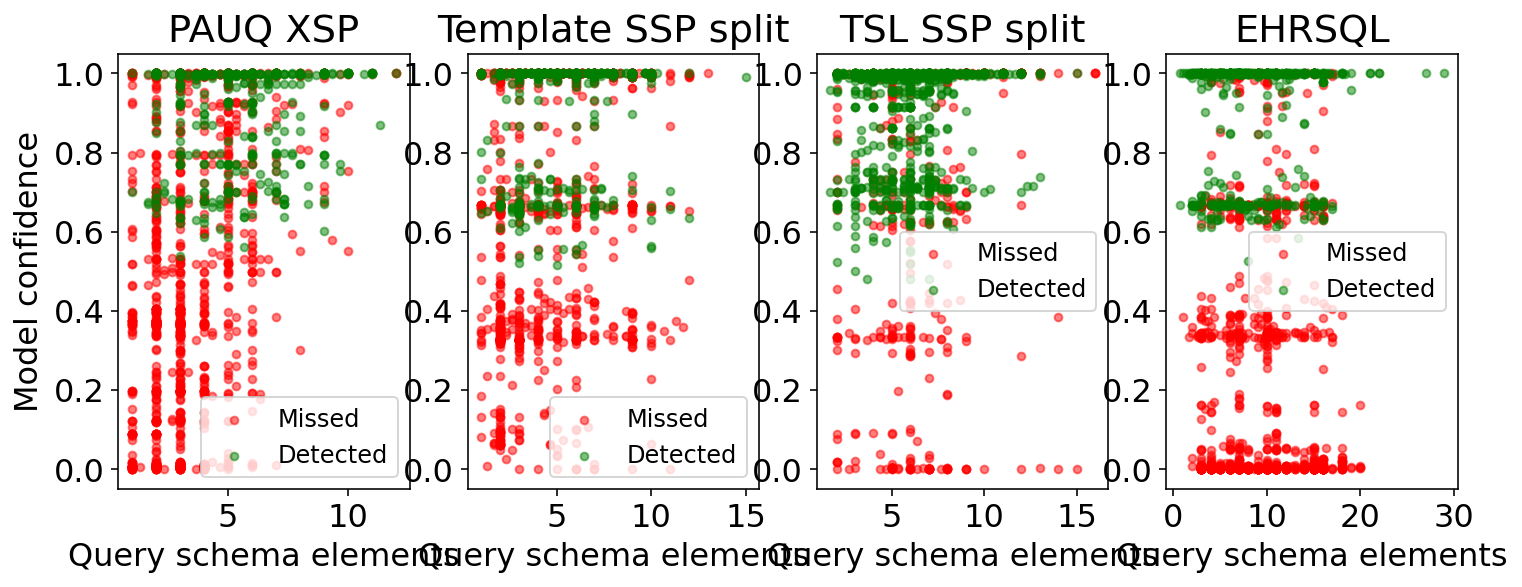

In [5]:
import random

model_name_list = ['t5-large', 't5-3b', 'dailsql', 'llama3_lora', 'llama3_sft']
splits = ['pauq_xsp', 'template_ssp', 'tsl_ssp', 'ehrsql']

fig, axs = plt.subplots(1, len(splits), figsize=(12, 4))


for split_idx, split_name in enumerate(splits):
    schema_elements_array = np.array([-1])
    scores_array = np.array([-1])
    predicted_targets_array = np.array([-1])
    for model_idx, model_name in enumerate(model_name_list):
    
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            pred, proba_preds = score_by_gmm(dev_sc, dev_tr, test_sc, test_tr)
            
            seeds = data_constants.SEED_LIST[model_name]
            gold_list = support_functions.read_gold_dataset_test(split_name, data_constants.GOLD_TEST_SPLIT_PATH)
            schema_elements_seed_array = []
            for seed in seeds:
                predicted_dict = support_functions.read_preds_dataset_test(split_name, model_name, seed,
                                                                    data_constants.SPLITS_PREDICTIONS_PATH)
                schema_elements_seed_array.append(calculate_number_of_schema_items(gold_list, predicted_dict))
            test_schema_elements_matrix = np.array(schema_elements_seed_array).T
            
            _, _, test_schema_elements, test_schema_tr = support_functions.create_split(test_schema_elements_matrix, targets)
            
            np.testing.assert_array_equal(test_tr, test_schema_tr)

            schema_elements_avg_vector = test_schema_elements.mean(axis=1).reshape(-1)
            proba_avg_vector = proba_preds.mean(axis=1).reshape(-1)
            
            major_true_target_vector = np.array([np.bincount(row).argmax() for row in test_tr]).reshape(-1)
            major_pred_target_vector = np.array([np.bincount(row).argmax() for row in pred]).reshape(-1)
            
            prediction_hue = major_true_target_vector & major_pred_target_vector
            
            schema_elements_array = np.concatenate((schema_elements_array, schema_elements_avg_vector), axis=0)
            scores_array = np.concatenate((scores_array, proba_avg_vector), axis=0)
            predicted_targets_array = np.concatenate((predicted_targets_array, prediction_hue), axis=0)
            
    schema_elements_array = schema_elements_array[1:]
    scores_array = scores_array[1:]
    predicted_targets_array = predicted_targets_array[1:]
        
        
    random_indexes = np.array(random.sample(range(len(predicted_targets_array)), 2000))

    sampled_schema_elements_array = schema_elements_array[random_indexes].reshape(-1,1)
    sampled_scores_array = scores_array[random_indexes].reshape(-1,1)
    sampled_predicted_targets_array = predicted_targets_array[random_indexes].reshape(-1,1)
    
    stacked_arrays = np.concatenate([sampled_schema_elements_array, sampled_scores_array, sampled_predicted_targets_array], axis=1)
    classes = np.unique(sampled_predicted_targets_array)
    
    stacked_arrays = stacked_arrays[stacked_arrays[:, 0] != 0]
    
    plot_title = f"{data_constants.SPLITS_NAMES[split_name]}"
    axs[split_idx].set_title(plot_title)
    
    class_color = {1: 'green', 0: 'red'}
    label_name = {1: 'Detected', 0: 'Missed'}
    for c in classes:
        x_dim = stacked_arrays[stacked_arrays[:, 2] == c][:, 0]
        y_dim = stacked_arrays[stacked_arrays[:, 2] == c][:, 1]
        axs[split_idx].scatter(x = x_dim,
                              y = y_dim,
                              c=class_color[c], label=label_name[c], s=15,
                              alpha=0.5)
    

    
plt.rcParams.update({'font.size': 12})

axs[0].set_ylabel('Model confidence')

for ax in axs:
    ax.set_xlabel('Query schema elements')
    ax.legend(prop={'size': 12})
    ax.set_ylim(-0.05, 1.05)
    
    
fig.savefig('confidence estimation data/schema_to_confidence.png', dpi=300, bbox_inches='tight', transparent=True)

### EHRSQL score of unasnwerable/low-generalization detection

In [6]:
def make_ehrsql_array(dataset):
    type_list = []
    for sample in dataset:
        if sample['sql'] == 'null':
            type_list.append(-1)
        else:
            type_list.append(1)
    return np.array(type_list)


ehrsql_dataset = support_functions.read_gold_dataset_test('ehrsql', data_constants.GOLD_TEST_SPLIT_PATH)
ehrsql_array = make_ehrsql_array(ehrsql_dataset).reshape(-1,1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 315505.53it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 513507.42it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 385747.72it/s]


(1167, 1) (1167, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 380381.78it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 401044.88it/s]


(1167, 3) (1167, 3)


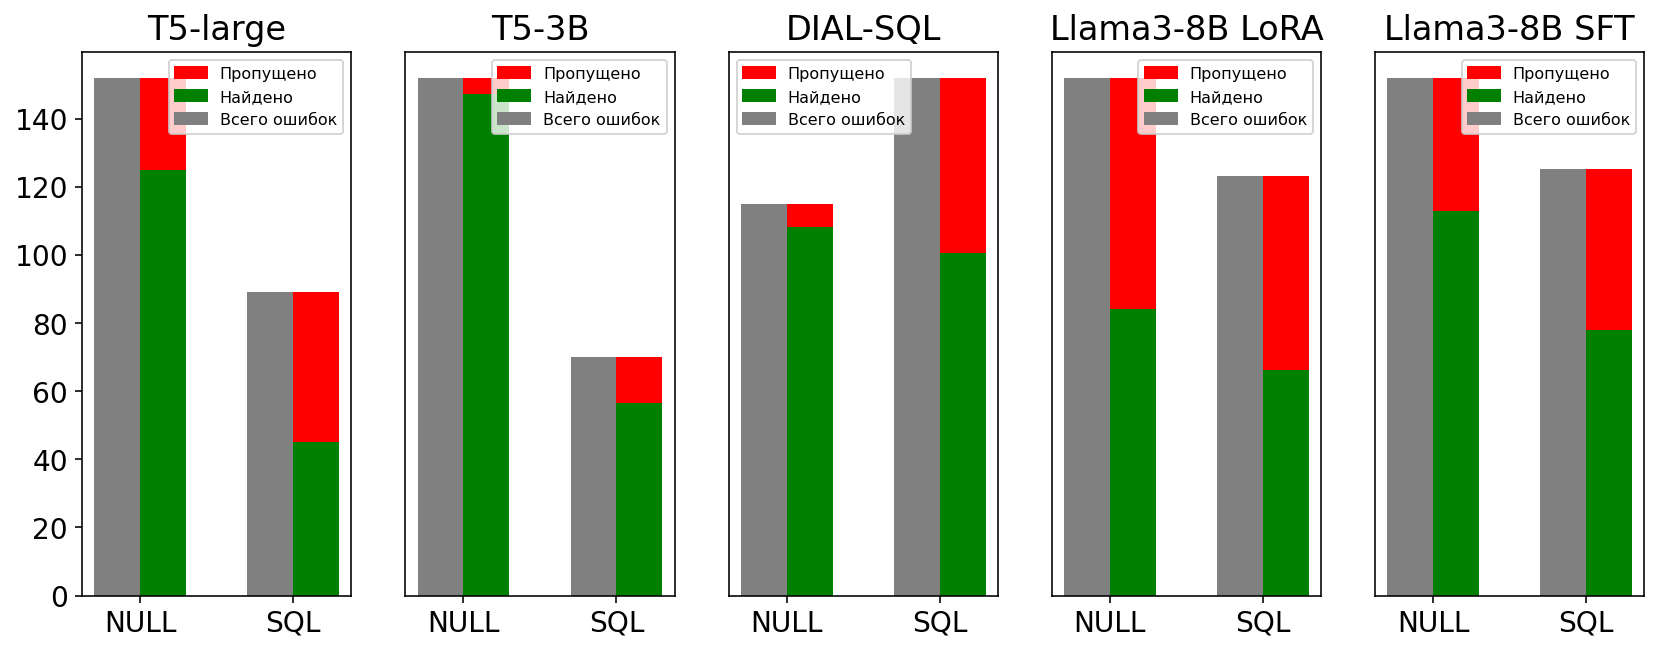

In [8]:
plt.rcParams.update({'font.size': 14})

colors = {'Missed':'red', 'Detected':'green', 'Total Errors': 'gray'}  

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

fig, axs = plt.subplots(1, len(model_name_list), figsize=(14, 5))

for model_idx, model_name in enumerate(model_name_list):
    scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
    
    if scores is not None:
        dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
        pred, proba_preds = score_by_gmm(dev_sc, dev_tr, test_sc, test_tr)
        

        _, _, ehrsql_query_type_test, ehrsql_query_type_tr = support_functions.create_split(ehrsql_array, targets)
        
        proba_avg_vector = proba_preds.mean(axis=1).reshape(-1)
        
        seeds = data_constants.SEED_LIST[model_name]
        
        gold_uns_dict = {"NULL": 0, "SQL": 0}
        predicted_dict = {"NULL": 0, "SQL": 0}
        for idx, _ in enumerate(seeds):
            major_true_target_vector = test_tr[:, idx]
            major_pred_target_vector = pred[:, idx]

            unans_idx_list = []
            ans_idx_list = []

            for idx, (query_type, true_status, predicted_status) in enumerate(zip(ehrsql_query_type_test, major_true_target_vector, major_pred_target_vector)):
                if query_type == 1 and true_status == 1:
                    gold_uns_dict['SQL'] += 1
                    if predicted_status == 1:
                        predicted_dict['SQL'] += 1
                elif query_type == -1 and true_status == 1:
                    gold_uns_dict['NULL'] += 1
                    if predicted_status == 1:
                        predicted_dict['NULL'] += 1
                        
        gold_uns_dict['NULL'] /= len(seeds)
        gold_uns_dict['SQL'] /= len(seeds)
        
        predicted_dict['NULL'] /= len(seeds)
        predicted_dict['SQL'] /= len(seeds)
        
        query_types = gold_uns_dict.keys()
        query_counts = np.array(list(gold_uns_dict.values()))
        detection_counts = np.array(list(predicted_dict.values()))
        missed_counts = query_counts - detection_counts
        
        x = np.arange(2)
        width = 0.30 
        multiplier = 0
        
        
        offset = width * multiplier
        axs[model_idx].bar(x + offset, query_counts, width, label=query_types, 
                           align='edge', color='gray')
        multiplier += 1

        offset = width * multiplier
        
        axs[model_idx].bar(x + offset, detection_counts, width, label=query_types, 
                           align='edge', color='green')
        axs[model_idx].bar(x + offset, missed_counts, width, bottom=detection_counts, 
                           label=query_types, align='edge', color='red')

        
        axs[model_idx].set_xticks(x + 0.30, query_types)

        
        plot_title = f"{data_constants.MODEL_NAMES[model_name]}"
        axs[model_idx].set_title(plot_title)
        
        axs[model_idx].legend(handles, labels, prop={'size': 8})


    

for ax in axs[1:]:
    ax.tick_params(left = False, labelleft = False) 
    
    
fig.savefig('confidence estimation data/ehrsql_bar_plot_error_type_detection.png', dpi=300, bbox_inches='tight', transparent=True)